![picture of Boston skyline from the Charles River](https://images.unsplash.com/photo-1560799260-b737af7dd0fc?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=2462&q=80)
_Photo by Prateek Pisat on [Unsplash](https://unsplash.com/photos/SFsKWydc7qY)_

# Mapping Boston's Food Scene
Prepared by Brandon Bellanti<br>
Last updated May 1, 2021

---

# Table of Contents
1. [Introduction](#Introduction/Business-Problem)
2. [Data](#Data)
3. [Methodology](#Methodology)
    * [Collect data](#Collect-data)
    * [Explore data](#Explore-data)
    * [Cluster data](#Cluster-data)
4. [Results](#Results)
5. [Discussion](#Discussion)
6. [Conclusion](#Conclusion)

---
# Introduction/Business Problem

In this project, I analyze and cluster Boston nieghborhoods to find which ones are most similar based on their food venues. I'll look at aspects like categories of venue, price tier, rating, and venue location.

Some of the questions I'm interested in answering are:

* What are the most common categories for food venues in Boston? In each neighborhood?
* Do higher prices correlate with higher ratings?
* Does average food venue price correspond with income, either per-capita or by household?
* Are restaurants of a given food type distrubuted evenly across the city, or are they clustered together? If they're clustered, is there a correlation between the type of food and the demographics of that neighborhood?

The audience for this analysis is anyone interested in exploring Boston's food scene. One practical way it could be used is by someone who wants to open a restaurant in Boston: they would be able to see where similar restaurants – their competition – already exist or perhaps do not exist.

*[Jump to top](#Table-of-Contents)*

---
# Data

My data will come from two main sources, Boston's open data hub – [Analyze Boston](https://data.boston.gov/) – and the Foursquare API.

I'll use datasets available on Analyze Boston for [neighborhood](http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.csv) and [demographic data](https://data.boston.gov/dataset/neighborhood-demographics/resource/d8c23c6a-b868-4ba4-8a3b-b9615a21be07?view_id=875bddaa-ffb9-4eaa-bdb5-1b77b414182b) like income and population.

I'll use the Foursquare API for venue data. Once I have coordinate data for each Boston neighborhood (returned using the geopy library and the neighborhood data from Analyze Boston), I will call the `/venues` endpoint of the Foursquare API and search for nearby venues that have the categoryId `Food`.

Searching by categoryId also includes all venues in child categories and their children, so I will group the venues by common parent categories to have fewer values overall. Since the results of the standard `/venues` endpoint does not contain parent category information, I'll build a separate reference dataframe with the hierarchy on the Foursquare API [Venue Categories](https://developer.foursquare.com/docs/build-with-foursquare/categories/) page. 

For each venue, I am interested in more specific details such as price and rating. These details are accessed through a Premium endpoint - `/venues/VENUE_ID` – and I am limited to 500 Premium calls per day, so I will store the returned data to CSV files. This way, I can build a small cache of data over a couple of days and collect all the data I need.

I will use the K-Means algorithm to cluster the venues.

*[Jump to top](#Table-of-Contents)*

---
# Methodology

The method I used is fairly straightforward and can be grouped into three stages:
1. Collect the data
2. Explore the data
3. Cluster the data

Each stage is described in detail below, along with the code I used.

Before I begin with collection, analysis, and clustering, I import the Python libraries that I'll be using and load my credentials for accessing the Foursquare API.

In [364]:
# import libraries
import pandas as pd, numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.style.use('ggplot')
import seaborn as sns
import json
import requests
import folium # map rendering library

from sklearn import preprocessing
from sklearn.cluster import KMeans

In [315]:
# API credentials for the Foursquare API

CLIENT_ID = '##########' # your Foursquare ID
CLIENT_SECRET = '##########' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Collect data

### Coordinates for Boston neighborhoods

The City of Boston publishes quite a bit of data publicly through the **Analyze Boston** website ([data.boston.gov](https://data.boston.gov/)). I used the `read_csv()` method in Pandas to build a dataframe from their [Boston Neighborhoods](https://data.boston.gov/dataset/boston-neighborhoods1) dataset, dropping the columns I didn't need.

In [5]:
url = 'http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.csv'
neighborhoods_df = pd.read_csv(url)
neighborhoods_df.drop(columns=['ShapeSTArea','ShapeSTLength'],inplace=True)

In [4]:
# print numbered list of Boston neighborhoods
neighborhoods = neighborhoods_df['Name'].unique()
for i,neighborhood in enumerate(sorted(neighborhoods),1):
    print(f"{i})",neighborhood)

1) Allston
2) Back Bay
3) Bay Village
4) Beacon Hill
5) Brighton
6) Charlestown
7) Chinatown
8) Dorchester
9) Downtown
10) East Boston
11) Fenway
12) Harbor Islands
13) Hyde Park
14) Jamaica Plain
15) Leather District
16) Longwood
17) Mattapan
18) Mission Hill
19) North End
20) Roslindale
21) Roxbury
22) South Boston
23) South Boston Waterfront
24) South End
25) West End
26) West Roxbury


<br>
I need coordinate data (latitude and longitude) to get an accurate result set of nearby restaurants when I call the Foursquare API, so I created empty columns in my dataframe, used a function in the geopy library to fetch the coordinates for each neighborhood, and add the coordinates to the new columns.

In [38]:
# create empty series for latitude and longitude
neighborhoods_df[['Lat','Long']] = np.nan

In [6]:
# fetch the coordinates for Boston
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Boston, Massachusetts'
geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)

boston_lat, boston_long = location.latitude, location.longitude

print('The coordinates of {} are {}, {}'.format(address,boston_lat,boston_long))

The coordinates of Boston, Massachusetts are 42.3602534, -71.0582912


In [7]:
# fetch the coordinates for each neighborhood in Boston and add to the dataframe
neighborhoods_df.set_index('Name',inplace=True)

for neighborhood in neighborhoods_df.index:
#     print(neighborhood)
    address = f'{neighborhood}, Boston, Massachusetts'
    geolocator = Nominatim(user_agent="boston_explorer")
    location = geolocator.geocode(address)
    neighborhoods_df.loc[neighborhood,'Lat'] = location.latitude
    neighborhoods_df.loc[neighborhood,'Long'] = location.longitude

neighborhoods_df.reset_index(inplace=True)

neighborhoods_df.head()

,Name,OBJECTID,Acres,Neighborhood_ID,SqMiles,Lat,Long
0,Roslindale,27,1605.568237,15,2.51,42.291209,-71.124497
1,Jamaica Plain,28,2519.245394,11,3.94,42.309820,-71.120330
2,Mission Hill,29,350.853564,13,0.55,42.332560,-71.103608
3,Longwood,30,188.611947,28,0.29,42.341533,-71.110155
4,Bay Village,31,26.539839,33,0.04,42.350011,-71.066948


<br>
With the coordinate data for each neighborhood, I can build a map of Boston with markers and details for each neighborhood.

In [398]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[42.324843,-71.095016], zoom_start=12) # use coordinates for Roxbury, most central

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods_df['Lat'], neighborhoods_df['Long'], neighborhoods_df['Name']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#236CA7',
        fill=True,
        fill_color='#236CA7',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    
map_boston

### Foursquare API category hierarchy

Building a hierarchy of categories for grouping restaurants by type was more difficult than I anticipated.

The child categories are nested under their parent categories, but the depth of the child categories is unknown. So I had to develop a way to recursively loop through the categories, which I did with the `cat_grouper()` function below.

First, I called the `venues/categories` endpoint of the API to get a JSON encoded version of their hierarchy.

In [139]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
)

results = requests.get(url).json()

In [140]:
# print all top-level categories in the Foursquare API hierarchy
categories = results['response']['categories']

for category in categories:
    print(category['name'])

Arts & Entertainment
College & University
Event
Food
Nightlife Spot
Outdoors & Recreation
Professional & Other Places
Residence
Shop & Service
Travel & Transport


<br>

I isolated the Food category from the results of the API categories call using list comprehension to take the element whose dictionary value for the key `name` was `Food`.

In [141]:
# select food parent category and all descendent categories
food_category = [cat for cat in categories if cat['name']=='Food'][0]

<br>

Then, for each child category of the Food category, I built a flattened list of descendent categories. These lists also contained the original child category, so I took the first value of each list as the name of the subcategory.
<br>

_**Note:** For the sake of simplicity, I'm only grouping by the first level of child categories in the Food category. This reduces the number of possible Food subcategories from 357 to 92. This is still a large number, and could be reduced further by manual grouping._

In [142]:
# loop recursively through child categories of the food category
# append children to list and add that list to a dictionary

def cat_grouper(category):
    subcategory_list.append(category['name'])
    child_cats = category['categories']
    if len(child_cats)>0:
        for child in child_cats:
            cat_grouper(child)
            
category_dict = {}

for category in food_category['categories']:
    
    subcategory_list = []
    cat_grouper(category)
    group_name = subcategory_list[0]
    group = subcategory_list[1:]
    category_dict[group_name] = group

In [143]:
# print food venue category hierarchy example
for category, subcategories in category_dict.items():
    print(category,f"({len(subcategories)} subcategories)" if subcategories else '')
    if subcategories:
        for subcategory in subcategories:
            print('\t' + subcategory)
        break # stop loop after first subcategory example

print('...')

Afghan Restaurant 
African Restaurant (2 subcategories)
	Ethiopian Restaurant
	Mauritian Restaurant
...


<br>

Lastly, I wrote a function `find_parent()` that takes in a category and determines wether or not it is a top-level category. If the category is a descendent, the function returns the top-level category. This is for grouping the food venue categories later.

In [144]:
# function for finding parent category
def find_parent(category):
    
    # if category is a top-level category, return itself
    if category in category_dict.keys():
        return category
    
    # if category is a subcategory, return the top-level category
    else:
        for parent, children in category_dict.items():
            if category in children:
                return parent

### Venue details

To build a set of venues that I can use to analyze and cluster Boston neighborhoods, I used the `venues/explore` endpoint of the Foursquare API, and adapted the `getNearbyVenues()` function from one of the Coursera labs

I limited my results by the Food `categoryID` only (4d4b7105d754a06374d81259) by appending that string to the url for the `get()` request. I iterated through each neighborhood, passing the neighborhood coordinates and requesting 100 nearby venues for each. Each neighborhood set of 100 were added to a larger matrix.

Then, I built a dataframe of the results and added the appropriate column names.

In [90]:
def getNearbyFoodVenues(names, latitudes, longitudes, radius=1000):
    categoryId = '4d4b7105d754a06374d81259' # food category
    venues_list=[] # list to hold venues data
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:            
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location'].get('city',''), # use .get() method to set default value if city not returned
            v['venue']['location'].get('address',''), # use .get() method to set default value if address not returned
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['distance'],  
            v['venue']['categories'][0]['name'])])

    # loop through list of venues data and build a datafram
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue Name', 
                  'Venue ID',
                  'Venue City',
                  'Venue Address',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Distance', 
                  'Venue Category']
    
    # return dataframe
    return(nearby_venues)

In [78]:
food_venues = getNearbyFoodVenues(names=neighborhoods_df['Name'],
                                   latitudes=neighborhoods_df['Lat'],
                                   longitudes=neighborhoods_df['Long']
                                  )

Roslindale
Jamaica Plain
Mission Hill
Longwood
Bay Village
Leather District
Chinatown
North End
Roxbury
South End
Back Bay
East Boston
Charlestown
West End
Beacon Hill
Downtown
Fenway
Brighton
West Roxbury
Hyde Park
Mattapan
Dorchester
South Boston Waterfront
South Boston
Allston
Harbor Islands


<br>

There is quite a bit of overlap between neighborhoods in the nearby search results; many food venues in my dataframe are duplicates. One idea I had was to match the original neighborhood value with the returned city value from the API, but the city value was not always included and the formatting. Instead, I sorted the venues by distance from the original neighborhood coordinates, and dropped the duplicates by their ID.
<br>

_**Note:** This is not a perfect solution, as a venue on the edge of one neighborhood might actually be closer to the coordinates for a different neighborhood, thus skewing the neighborhood results. But, for the sake of simplicity and time, this was the solution I decided to use._

In [131]:
# drop any overlapping search results from nearby neighborhoods based on distance
food_venues = food_venues.sort_values(by='Venue Distance').drop_duplicates('Venue ID')
print('{} food venues found in Boston'.format(food_venues.shape[0]))

944 food venues found in Boston


<br>

Because the Foursquare category hierarchy is so granular, I decided to use only the top-level food categories for a more high-level perspective. I already wrote a function `find_parent()` that traverses the category hierarchy and matches subcategories with their parent category, so I used that function to create a new column with category groups.

In [149]:
# add series for parent categories
food_venues['Category Group'] = food_venues['Venue Category'].apply(find_parent)

print(f"Number of categories before grouping: {food_venues['Venue Category'].nunique()}")
print(f"Number of categories after grouping: {food_venues['Category Group'].nunique()}")

Number of categories before grouping: 77
Number of categories after grouping: 51


<br>

One of the biggest challenges I faced during this project was the need for data accessible only through the Foursquare API's premium enpoint `venues/VENUE_ID`. So I was limited to 500 premium calls per day to collect what I needed, and I had nearly 1000 venues.

To make sure I was working with the same result set from the original `venues/explore` request, I wrote the dataframe to a CSV. Then, each time I worked on the project, I loaded that dataset rather than resending the request and building a new `food_venues` frame each time.

This way, I could split the venues into two groups and make two rounds of calls to the premium endpoint.

In [120]:
# write dataframe to file for future reference
path = './data/food_venues.csv'
food_venues.to_csv(path,index=False)

In [130]:
# load dataframe from file
path = './data/food_venues.csv'
food_venues = pd.read_csv(path)
food_venues.shape

(944, 12)

In [4]:
# divide venues in two groups
fv1 = food_venues[:450]
fv2 = food_venues[450:]

<br>

With the data set split in two, I collected venue-specific data such as rating, rating count and price, looping through the request results and building a dataframe in the same way as the `getNearbyFoodVenues()` function before.

In [6]:
def getVenueDetails(venue_ids):
    venues_list = []
    for venue_id in venue_ids:
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)

        # make the GET request
        r = requests.get(url).json()['response']
        try:
            v = r.get('venue',{})

            venue_details = [(
                v.get('id',None),
                v.get('name',None),
                v.get('rating',None),
                v.get('ratingSignals',None),
                v.get('price',{}).get('tier',None),
                v.get('price',{}).get('message',None)
            )]

            venues_list.append(venue_details)
        except:
            print(r)


    venue_details = pd.DataFrame([item for venue_details in venues_list for item in venue_details])
    venue_details.columns = [
        'Venue ID',
        'Venue Name',
        'Venue Rating',
        'Venue Rating Signals',
        'Venue Price Tier',
        'Venue Price Message']

    return venue_details

<br>

For each subset of venue details returned by the `getVenueDetails()` function, I wrote the dataframe to a CSV file. When I had the full results set saved, I read the CSV files back into a new dataframe and merged related columns from the original venues dataframe like location and categories.

In [ ]:
# get details for first half of venue dataset
fv1_details = getVenueDetails(fv1['Venue ID'])
fv1_details.shape

In [ ]:
# write data to file for reference
# fv1_details.to_csv('./data/food_venue_details_1.csv')

In [ ]:
# get details for first half of venue dataset
fv2_details = getVenueDetails(fv2['Venue ID'])
fv2_details.shape

In [ ]:
# write data to file for reference
# fv2_details.to_csv('./data/food_venue_details_2.csv')

In [153]:
# load datasets and combine
fv1_details = pd.read_csv('./data/food_venue_details_1.csv',index_col=0)
fv2_details = pd.read_csv('./data/food_venue_details_2.csv',index_col=0)
fv_details = pd.concat([fv1_details,fv2_details],ignore_index=True)
fv_details.shape

(944, 6)

In [154]:
food_venues = fv_details.merge(food_venues[['Venue ID',
                                            'Neighborhood',
                                            'Venue Category',
                                            'Category Group',
                                            'Venue Latitude',
                                            'Venue Longitude']],
                               left_on='Venue ID',
                               right_on='Venue ID',
                               how='left')
food_venues.shape

(944, 11)

## Explore data

In this section, I used exploratory analyses to better understand my dataset and identify any features I could use for the K-Means algorithm to cluster the venues.

I generally state the question before the code I ran and the answer after the code, but I omitted the answers for questions with self-explanatory results.

In [365]:
# function for printing a formatted series
def series_print(series,label=''):
    '''Print an numbered series with index names (keys) and values.'''
    for i,(k,v) in enumerate(series.items(),1):
        print('{}) {}:  {} {}'.format(i,k,v,label))

<br>

**Question: Which venues have the most locations?**

In [366]:
# venues with the most locations
series_print(food_venues['Venue Name'].value_counts().head(),label='venues')

1) Dunkin':  28 venues
2) SUBWAY:  11 venues
3) sweetgreen:  8 venues
4) Tatte Bakery & Cafe:  8 venues
5) Domino's Pizza:  7 venues


**Answer:** No surprise for anyone familiar with Boston, Dunkin' is the venue with the most locations across the city.

<br>

**Question: Which neighborhoods have the most venues?**

In [367]:
# venues in each neighborhood
neighborhood_counts = food_venues.value_counts('Neighborhood')
series_print(neighborhood_counts.sort_values(ascending=False).head(),label='venues')

1) Fenway:  83 venues
2) Back Bay:  72 venues
3) North End:  64 venues
4) South End:  60 venues
5) Brighton:  57 venues


<br>

**Question: What is the mean rating for each neighborhood?**<br>
*The Foursquare rating ranges from 0-10.*

In [368]:
# mean rating for each neighborhood
neighborhood_ratings = food_venues.groupby('Neighborhood')['Venue Rating'].mean()
series_print(neighborhood_ratings.sort_values(ascending=False).head())

1) North End:  8.253125 
2) South Boston Waterfront:  8.232558139534884 
3) Leather District:  8.166666666666666 
4) Back Bay:  8.165277777777778 
5) Allston:  8.163829787234045 


<br>

**Question: What is the mean price tier for each neighborhood?**<br>
*The Foursquare price tier ranges from 1-4.*

In [369]:
# mean price tier for each neighborhood
neighborhood_prices = food_venues.groupby('Neighborhood')['Venue Price Tier'].mean()
series_print(neighborhood_prices.sort_values(ascending=False).head())

1) Bay Village:  2.257142857142857 
2) Back Bay:  2.142857142857143 
3) Beacon Hill:  2.12 
4) North End:  2.109375 
5) South Boston Waterfront:  2.0232558139534884 


<br>

**Question: What are the most common food venue categories in Boston?**

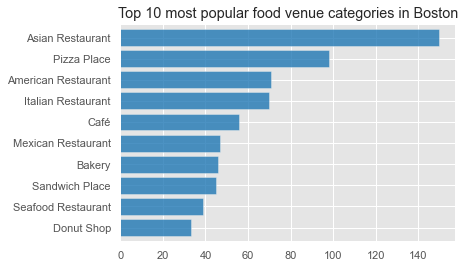

In [370]:
# most popular food venues types
food_venues['Category Group'].value_counts().head(10).sort_values(ascending=True).plot.barh(width=.8,color='tab:blue',alpha=.8)
plt.title('Top 10 most popular food venue categories in Boston')
plt.show()

**Answer:** The most common restaurant type in Boston is Asian Restaurant, followed by Pizza Place, and American Restaurant, and Italian Restaurant.

_**Note:** Remember from before, the Asian Restaurant category in the Foursquare category hierarchy has the most subcategories (88), so from one perspective, it makes sense that it is the most frequent category grouping in this dataset. If the Pizza Place category was grouped with the Italian Restaurant category rather than being distinct, it would be the most frequent category._

<br>

**Question: What is the distribution of the venue ratings?**

<AxesSubplot:xlabel='Venue Rating', ylabel='Count'>

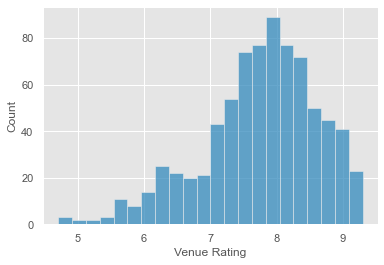

In [371]:
sns.histplot(food_venues,x='Venue Rating')

**Answer:** Most of the venues are rated between 7 and 9, with very few rated below 6.

<br>

**Question: How many venues are there in each price category?**

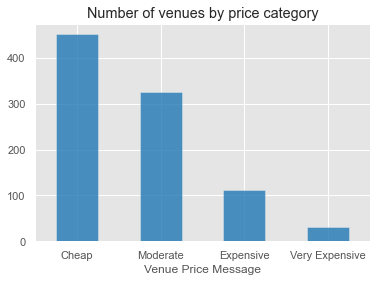

In [372]:
food_venues.value_counts('Venue Price Message').plot.bar(color='tab:blue', alpha=.8)
plt.title('Number of venues by price category')
plt.xticks(rotation=0)
plt.show()

**Answer:** Most venues are in the `Cheap` or `Moderate` price categories, with relatively few in the `Very Expensive` category

<br>

**Question: Does venue rating correspond with price?**

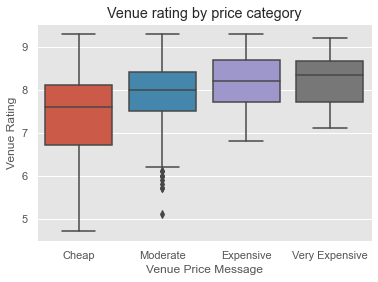

In [373]:
# plot venue rating by price - box plot
sns.boxplot(x="Venue Price Message", y="Venue Rating", data=food_venues)
plt.title('Venue rating by price category')
plt.show()

**Answer:** The median rating increases as the price tier increases. The range of ratings in each price category is smaller as the price increases, with `Very Expensive` restaurants having the smallest range of all, which is likely related to that category having the fewest number of venues.

Another way to look at this relationship between price and rating is through a regression line.

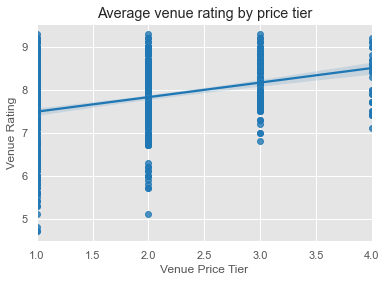

In [374]:
# plot venue rating by price
sns.regplot(data=food_venues,x='Venue Price Tier', y='Venue Rating',color='tab:blue')
plt.title('Average venue rating by price tier')
plt.show()

**Result:** There is a strong positive correlation between a venue's price tier and the average rating.

<br>

**Question: Do venues with multiple locations have lower ratings than restaurants with a single venue?**

In [375]:
# create series for multiple locations (boolean)
food_venues['Multiple Locations'] = food_venues.groupby('Venue Name')['Venue Name'].transform('count')>1
food_venues['Multiple Locations'] = food_venues['Multiple Locations'].astype(int)

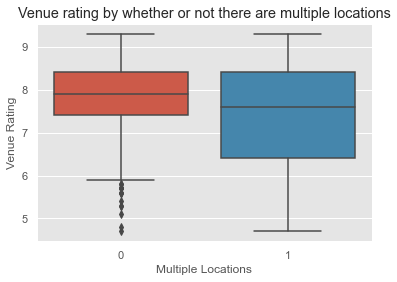

In [376]:
# plot venue rating by multiple locations - box plot
sns.boxplot(x="Multiple Locations", y="Venue Rating", data=food_venues)
plt.title('Venue rating by whether or not there are multiple locations')
plt.show()

In [377]:
for i, rating in food_venues.groupby('Multiple Locations')['Venue Rating'].mean().items():
    label = 'Single Location' if i == 0 else 'Multiple Locations'
    print('{}: {}'.format(label,rating))

Single Location: 7.81537267080745
Multiple Locations: 7.426515151515155


**Answer:** Yes, venues with multiple locations have lower mean and median ratings than venues with a single location.

<br>

**Question: Does average venue price correspond with per capita income by neighborhood?**

To answer this question, I compare mean per capita income with mean venue price in each neighborhood. Income data is from Analyze Boston and represents figures from 2019. I binned the data to see generally how the neighborhoods are divided, then used a regression plot in the Seaborn library to view all the points and see if there was a correlation.

In [378]:
income_path = "./data/boston_demographics/income.csv"
income_df = pd.read_csv(income_path)
income_df = income_df.drop(columns='Total Households').set_index('Neighborhood')
income_df.head()

,Mean Per Capita Income,Median Household Income,Median Family Income
Neighborhood,,,
Allston,"$34,149","$58,141","$73,975"
Back Bay,"$110,677","$111,185","$197,348"
Beacon Hill,"$100,005","$110,841","$205,960"
Brighton,"$41,261","$77,625","$92,364"
Charlestown,"$75,339","$127,400","$162,386"


In [379]:
# format string values as float values
def currency_formatter(string):
    string = string.strip().replace('$','').replace(',','')
    return float(string)

for col in ['Mean Per Capita Income','Median Household Income','Median Family Income']:
    income_df[col]=income_df[col].apply(currency_formatter)

In [380]:
# bin neighborhoods by per capita income
nbins = 5
income_df['Per Capita Bins'] = pd.cut(income_df['Mean Per Capita Income'], bins=nbins, labels=list(range(nbins)))
grouped = income_df.reset_index().groupby('Per Capita Bins')['Neighborhood'].apply(lambda x: ', '.join(x))
for i, neighborhoods in grouped.items():
    print('Bin {}: {}'.format(i,neighborhoods))

Bin 0: Dorchester, East Boston, Fenway, Longwood, Mattapan, Mission Hill, Roxbury
Bin 1: Allston, Brighton, Hyde Park, Jamaica Plain, Roslindale, West Roxbury
Bin 2: Charlestown, Downtown, South Boston, West End
Bin 3: Beacon Hill, North End, South End
Bin 4: Back Bay, South Boston Waterfront


In [381]:
# mean venue price tier by neighborhood
neighborhood_mean_price = food_venues.groupby('Neighborhood')['Venue Price Tier'].mean()

# combine mean venue price tier and income data
price_income = pd.concat([neighborhood_mean_price,income_df],axis=1)

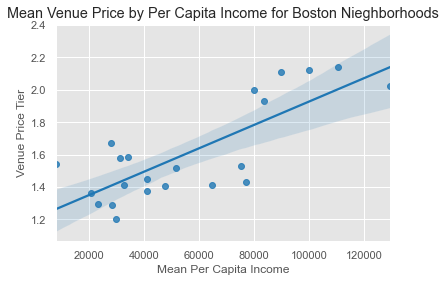

In [382]:
# plot mean per capita income and mean venue price tier
sns.regplot(data=price_income, y='Venue Price Tier',x='Mean Per Capita Income',color='tab:blue')
plt.title('Mean Venue Price by Per Capita Income for Boston Nieghborhoods')
plt.show()

**Answer:** Yes, there is a positive correlation between mean per capita income by neighborhood and mean venue price.

<br>

**Question: Is there a relationship betwen venue rating or price and venues per capita?**

I used the same dataset from Analyze Boston as before, but looked at population instead of income. I simply divided the number of venues by the population in each neighborhood. Then, I added mean price and rating data. I used the `df.corr()` method to view the Pearson coefficient for each pair of variables, and used the `df.style.background_gradient()` method to make it easier to see which pairs had a stronger correlation. Finally, I made another regression plot to visualize one of the relationships that had a moderate correlation according to the table.

In [383]:
pop_path = "./data/boston_demographics/race.csv"
pop_df = pd.read_csv(pop_path)
pop_df = pop_df[['Neighborhood','Total Population']]
pop_df['Total Population'] = pop_df['Total Population'].str.replace(',','').astype(int)
pop_df.set_index('Neighborhood',inplace=True)

In [384]:
neighborhood_venues = food_venues.value_counts('Neighborhood').to_frame(name='Venues')

In [385]:
density_df = pd.concat([pop_df,neighborhoods_df.set_index('Name')['SqMiles'], neighborhood_venues],axis=1)
density_df.head()

,Total Population,SqMiles,Venues
Allston,19261.0,1.56,48.0
Back Bay,17783.0,0.62,72.0
Beacon Hill,9648.0,0.31,25.0
Brighton,55297.0,2.88,57.0
Charlestown,19890.0,1.36,38.0


In [386]:
# add column for venues per capita
density_df['Venues Per Capita'] = density_df['Venues'] / density_df['Total Population']
# add column for venues per square mile
density_df['Venues Per Sq Mi'] = density_df['Venues'] / density_df['SqMiles']
# add column for mean rating by neighborhood
density_df.insert(0,'Mean Rating',value=food_venues.groupby('Neighborhood')['Venue Rating'].mean())
# add column for mean price by neighborhood
density_df.insert(0,'Mean Price',value=food_venues.groupby('Neighborhood')['Venue Price Tier'].mean())

density_df.head()

,Mean Price,Mean Rating,Total Population,SqMiles,Venues,Venues Per Capita,Venues Per Sq Mi
Allston,1.586957,8.163830,19261.0,1.56,48.0,0.002492,30.769231
Back Bay,2.142857,8.165278,17783.0,0.62,72.0,0.004049,116.129032
Beacon Hill,2.120000,7.760000,9648.0,0.31,25.0,0.002591,80.645161
Brighton,1.375000,7.186486,55297.0,2.88,57.0,0.001031,19.791667
Charlestown,1.527778,7.283333,19890.0,1.36,38.0,0.001911,27.941176


In [387]:
density_df.corr().style.background_gradient()

,Mean Price,Mean Rating,Total Population,SqMiles,Venues,Venues Per Capita,Venues Per Sq Mi
Mean Price,1.000000,0.805386,-0.519462,-0.572796,0.436403,0.617801,0.434860
Mean Rating,0.805386,1.000000,-0.531804,-0.622943,0.443577,0.523986,0.447621
Total Population,-0.519462,-0.531804,1.000000,0.825631,-0.202676,-0.546963,-0.417014
SqMiles,-0.572796,-0.622943,0.825631,1.000000,-0.311356,-0.546751,-0.456628
Venues,0.436403,0.443577,-0.202676,-0.311356,1.000000,0.407265,-0.025762
Venues Per Capita,0.617801,0.523986,-0.546963,-0.546751,0.407265,1.000000,0.658912
Venues Per Sq Mi,0.434860,0.447621,-0.417014,-0.456628,-0.025762,0.658912,1.000000


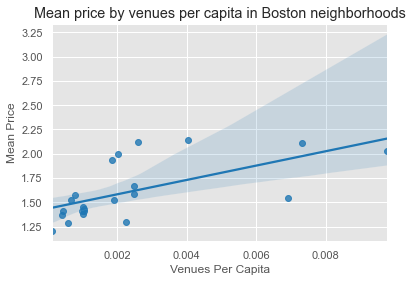

In [388]:
# plot Mean Price and Venues Per Capita, which have a Pearson coeeficient of 0.61 in the table above
sns.regplot(data=density_df, x='Venues Per Capita',y='Mean Price',color='tab:blue')
plt.title('Mean price by venues per capita in Boston neighborhoods')
plt.show()

**Answer:** There is correlation between venues per capita and mean price/rating by neighborhood.

_**Note:** Based on the spread in the confidence band for larger values of X, this relationship may not be strong enough to include in the final feature set._

<br>

**Question: What are the most common food venues by category in each neighborhood?**

One of the things I'm most interested in is understanding how types of venues are distributed across the city. I have a guess at how some areas of the city will look – more Italian Restaurants in the North End or Asian Restaurants in Chinatown – but I want to see what the data I have actually shows.

I use the `get_dummies()` method in Pandas to create boolean variables for each category group. Then I grouped by neighborhood and calcualted the mean of each category group compared to the other category groups in that neighborhood.

In [205]:
category_dummies = pd.get_dummies(food_venues['Category Group'])
category_dummies['Neighborhood'] = food_venues['Neighborhood']

In [206]:
neighborhoods_grouped = category_dummies.groupby('Neighborhood').mean()
neighborhoods_grouped.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,...,Restaurant,Salad Place,Sandwich Place,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Wings Joint
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allston,0.020833,0.0,0.020833,0.333333,0.0,0.000000,0.062500,0.0,0.00,0.000000,...,0.020833,0.000000,0.020833,0.020833,0.020833,0.000000,0.0,0.000000,0.020833,0.000000
Back Bay,0.000000,0.0,0.152778,0.138889,0.0,0.013889,0.027778,0.0,0.00,0.000000,...,0.041667,0.027778,0.027778,0.097222,0.000000,0.013889,0.0,0.027778,0.000000,0.000000
Bay Village,0.000000,0.0,0.085714,0.114286,0.0,0.000000,0.057143,0.0,0.00,0.057143,...,0.000000,0.028571,0.085714,0.114286,0.000000,0.000000,0.0,0.085714,0.028571,0.000000
Beacon Hill,0.000000,0.0,0.200000,0.080000,0.0,0.040000,0.040000,0.0,0.04,0.040000,...,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.040000,0.000000,0.000000
Brighton,0.000000,0.0,0.017544,0.263158,0.0,0.000000,0.052632,0.0,0.00,0.017544,...,0.017544,0.000000,0.035088,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.017544


<br>

With the neighborhood category groupings added to a dataframe, I can iterate through the rows and take the highest mean category group values to see which categories groups are the most frequent in each neighborhood.

In [207]:
for row in neighborhoods_grouped.iterrows():
    print(row[0])
    for i,cat in enumerate(row[1].sort_values(ascending=False).head().iteritems(),1):
        print('\t{}. {} ({})'.format(i,cat[0],round(cat[1],4)))
    print()


Allston
	1. Asian Restaurant (0.3333)
	2. Bakery (0.0625)
	3. Mexican Restaurant (0.0625)
	4. Diner (0.0417)
	5. Café (0.0417)

Back Bay
	1. American Restaurant (0.1528)
	2. Asian Restaurant (0.1389)
	3. Seafood Restaurant (0.0972)
	4. Mexican Restaurant (0.0833)
	5. Italian Restaurant (0.0694)

Bay Village
	1. Italian Restaurant (0.1429)
	2. Asian Restaurant (0.1143)
	3. Seafood Restaurant (0.1143)
	4. Pizza Place (0.1143)
	5. Steakhouse (0.0857)

Beacon Hill
	1. American Restaurant (0.2)
	2. Italian Restaurant (0.16)
	3. Pizza Place (0.16)
	4. Asian Restaurant (0.08)
	5. French Restaurant (0.08)

Brighton
	1. Asian Restaurant (0.2632)
	2. Pizza Place (0.1754)
	3. Café (0.0877)
	4. Bakery (0.0526)
	5. Greek Restaurant (0.0526)

Charlestown
	1. Café (0.2368)
	2. Pizza Place (0.1316)
	3. Sandwich Place (0.0789)
	4. Donut Shop (0.0789)
	5. Gastropub (0.0789)

Chinatown
	1. Asian Restaurant (0.5897)
	2. Bakery (0.1795)
	3. Pizza Place (0.0513)
	4. Restaurant (0.0256)
	5. Mexican Restauran

In [208]:
frequent_categories_dict = {}
for row in neighborhoods_grouped.iterrows():
    name = row[0]
    categories = [cat for cat in row[1].sort_values(ascending=False).head().index]
    frequent_categories_dict[name] = categories
    
neighborhood_categories = pd.DataFrame.from_dict(frequent_categories_dict,orient='index')
neighborhood_categories.columns = [
    '1st Most Frequent',
    '2nd Most Frequent',
    '3rd Most Frequent',
    '4th Most Frequent',
    '5th Most Frequent',
]

neighborhood_categories.head()

,1st Most Frequent,2nd Most Frequent,3rd Most Frequent,4th Most Frequent,5th Most Frequent
Allston,Asian Restaurant,Bakery,Mexican Restaurant,Diner,Café
Back Bay,American Restaurant,Asian Restaurant,Seafood Restaurant,Mexican Restaurant,Italian Restaurant
Bay Village,Italian Restaurant,Asian Restaurant,Seafood Restaurant,Pizza Place,Steakhouse
Beacon Hill,American Restaurant,Italian Restaurant,Pizza Place,Asian Restaurant,French Restaurant
Brighton,Asian Restaurant,Pizza Place,Café,Bakery,Greek Restaurant


**Answer:** It's clear that there are some similarities between neighborhoods based on the categories of the food venues located there.

_**Example**: The Fenway and South End neighborhoods each have `Asian restaurant`, `Café`, and `American Restaurant` as their first, second, and third most common venues respectively._

In [209]:
neighborhood_categories.loc[['Fenway','South End']]

,1st Most Frequent,2nd Most Frequent,3rd Most Frequent,4th Most Frequent,5th Most Frequent
Fenway,Asian Restaurant,Café,American Restaurant,Mexican Restaurant,Restaurant
South End,Asian Restaurant,Café,American Restaurant,Italian Restaurant,French Restaurant


## Cluster data

My original question for this data was which Boston neighborhoods are the most similar or dissimilar with regard to their food venues.

Based on the analysis above, I will use the following variables in my feature set for clustering:
1. Mean rating
2. Mean price (tier)
3. Percentage of venues with multiple locations
4. Most common restaurant types

<br>

I begin by calculating mean rating, price tier, and multiple-location percentages for each neighborhood.

In [249]:
features = food_venues.groupby('Neighborhood')[['Multiple Locations','Venue Rating','Venue Price Tier']].mean()
features.head()

,Multiple Locations,Venue Rating,Venue Price Tier
Neighborhood,,,
Allston,0.020833,8.163830,1.586957
Back Bay,0.166667,8.165278,2.142857
Bay Village,0.257143,8.145714,2.257143
Beacon Hill,0.120000,7.760000,2.120000
Brighton,0.175439,7.186486,1.375000


<br>

Then, I add the percentages each category grouping makes up in the nieghborhood.

In [250]:
features = pd.concat([neighborhoods_grouped,features],axis=1)
features.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,Breakfast Spot,...,Seafood Restaurant,Snack Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Wings Joint,Multiple Locations,Venue Rating,Venue Price Tier
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Allston,0.020833,0.0,0.020833,0.333333,0.0,0.000000,0.062500,0.0,0.00,0.000000,...,0.020833,0.020833,0.000000,0.0,0.000000,0.020833,0.000000,0.020833,8.163830,1.586957
Back Bay,0.000000,0.0,0.152778,0.138889,0.0,0.013889,0.027778,0.0,0.00,0.000000,...,0.097222,0.000000,0.013889,0.0,0.027778,0.000000,0.000000,0.166667,8.165278,2.142857
Bay Village,0.000000,0.0,0.085714,0.114286,0.0,0.000000,0.057143,0.0,0.00,0.057143,...,0.114286,0.000000,0.000000,0.0,0.085714,0.028571,0.000000,0.257143,8.145714,2.257143
Beacon Hill,0.000000,0.0,0.200000,0.080000,0.0,0.040000,0.040000,0.0,0.04,0.040000,...,0.000000,0.000000,0.000000,0.0,0.040000,0.000000,0.000000,0.120000,7.760000,2.120000
Brighton,0.000000,0.0,0.017544,0.263158,0.0,0.000000,0.052632,0.0,0.00,0.017544,...,0.000000,0.000000,0.000000,0.0,0.000000,0.017544,0.017544,0.175439,7.186486,1.375000


<br>

With my feature set collected and cleaned, I use the `StandardScalar()` method in sklearn's preprocessing library to turn my dataframe into a matrix for modeling.

In [281]:
X = features
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0]

array([-0.48507125,  4.89897949, -0.29212743, -0.86921015,  1.54799083,
       -0.32347166, -0.43185367,  0.32619232, -0.20412415, -0.20412415,
       -0.48780271, -0.48233064, -0.20412415, -0.25989597, -0.47465176,
        4.04145188, -0.20412415, -0.72568135,  1.13447782, -0.46664612,
        4.89897949, -0.20412415,  0.77104839, -0.67506198, -0.20412415,
        2.41566479, -0.20412415, -0.42598911, -0.61045032,  2.45056246,
        1.49112704, -0.66770287,  1.23814779,  0.56131112, -0.29398655,
       -0.51372136, -0.31322922,  0.05353588,  0.15869899, -0.42412777,
       -0.87668596, -0.20412415, -0.07029033, -0.50353386, -0.83032393,
       -0.28573196,  1.96503549, -0.32726369, -0.40047243, -0.54886015,
        0.5804547 , -0.28867513, -1.85332763,  1.11931927, -0.15002285])

<br>

With the feature set built and scaled, I ran the `KMeans` algorithm from sklearn to cluster the nieghborhoods, and added the cluster labels to my features dataframe

In [280]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(init='k-means++',n_clusters=kclusters, random_state=0,n_init=10).fit(X)

In [253]:
features.insert(0,'Cluster',kmeans.labels_)

<br>

*[Jump to top](#Table-of-Contents)*

---
# Results

The KMeans algorithm grouped the neighborhoods into 5 clusters. 

In [312]:
# concat clusters by neighborhood
neighborhood_clusters = features.reset_index().groupby('Cluster')['Neighborhood'].apply(lambda x: ', '.join(x))
for cluster,neighborhoods in neighborhood_clusters.items():
    print('Cluster',cluster)
    for i,neighborhood in enumerate(neighborhoods.split(', '),1):
        print(f"    {i}. {neighborhood}")
    print('-'*60)

Cluster 0
    1. Back Bay
    2. Bay Village
    3. Beacon Hill
    4. Downtown
    5. Leather District
    6. North End
    7. South Boston Waterfront
------------------------------------------------------------
Cluster 1
    1. Allston
    2. Brighton
    3. Chinatown
    4. East Boston
    5. Fenway
    6. Jamaica Plain
    7. Roslindale
    8. South End
------------------------------------------------------------
Cluster 2
    1. Dorchester
------------------------------------------------------------
Cluster 3
    1. West End
------------------------------------------------------------
Cluster 4
    1. Charlestown
    2. Hyde Park
    3. Longwood
    4. Mattapan
    5. Mission Hill
    6. Roxbury
    7. South Boston
    8. West Roxbury
------------------------------------------------------------


<br>

One way to analyze the clusters is to look at the mean values for some of the features I choose.

In [255]:
features.groupby('Cluster')[['Multiple Locations','Venue Rating','Venue Price Tier']].mean()

,Multiple Locations,Venue Rating,Venue Price Tier
Cluster,,,
0,0.149462,8.114145,2.045614
1,0.097402,7.690060,1.578455
2,0.176471,6.520000,1.200000
3,0.285714,7.857143,1.428571
4,0.221616,6.898773,1.405405


<br>

These values are easier to understand when they're visualized through some basic plots. I colored the neighborhoods by cluster to see how the results are distributed.

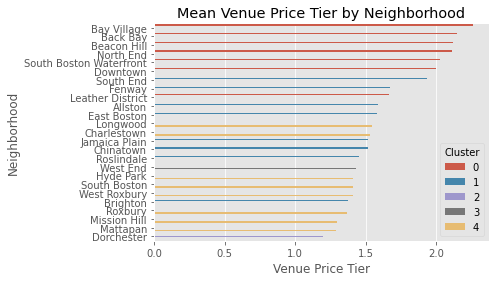

In [260]:
# plot mean venue price by neighborhood and cluster
plot_features = features.reset_index().sort_values(by='Venue Price Tier',ascending=False)
sns.barplot(data=plot_features, y='Neighborhood',x='Venue Price Tier',hue='Cluster')
plt.title('Mean Venue Price Tier by Neighborhood')
plt.show()

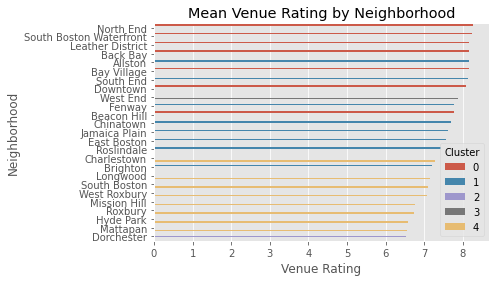

In [272]:
# plot mean venue rating by neighborhood and cluster
plot_features = features.reset_index().sort_values(by='Venue Rating',ascending=False)
sns.barplot(data=plot_features, y='Neighborhood',x='Venue Rating',hue='Cluster')
plt.title('Mean Venue Rating by Neighborhood')
plt.show()

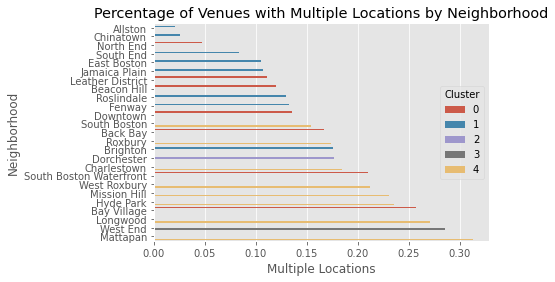

In [313]:
# plot mean multiple locations value by neighborhood and cluster
plot_features = features.reset_index().sort_values(by='Multiple Locations')
sns.barplot(data=plot_features, y='Neighborhood',x='Multiple Locations',hue='Cluster')
plt.title('Percentage of Venues with Multiple Locations by Neighborhood')
plt.show()

From the plots above, there are some clear differences between the clusters:

* **Cluster 0**: high price, high rating, low to moderately-low number of chains
* **Cluster 1**: medium-high price, medium-high ratings, low number of chains
* **Cluster 2**: low price, low rating, moderate number of chains
* **Cluster 3**: medium low price, medium rating, high number of chains
* **Cluster 4**: medium low price, low rating, moderately-high to high number of chains

*[Jump to top](#Table-of-Contents)*

---
# Discussion

**What went well**

Overall, I'm pleased with this project and the results. I set out to cluster neighborhoods based on the food venues, and I believe I've shown that is possible.

As a capstone for the entire IBM Data Science Professional Certificate, I can see a good deal of personal progress. I have a better understanding of how to visualize data in a meaningful way and how to look for correlation among variables. And I was able to complete the entire sequence from identifying and collecting the data to analyzing and clustering the data.

**What I'd do differently next time**

* Collect ALL venues, not just the first 100 in each neighborhood. The function I borrowed from the capstone course labs did not loop through the Foursquare results and resubmit the get request to exhaust the venues in each neighborhood. For the sake of time, I left it the way it was, meaning I would have a max of 2600 venues over 26 neighborhoods. But that number was decreased a great deal when I deduplicated the results based on overlap between nieghborhoods. If I were redoing this project, I would do more to make sure I had an exhaustive list of restaurants, though I think the list I did have was representative. 

* Use the category groupings values in each neighborhood to calculate homogeneity. When I looked at the most frequent category groups in each neighborhood by percentage, I noticed that the mean value for the first entry in some neighborhoods was much higher than others. For example, 0.58 or 58% of the restaurants in Chinatown had the category Asian Restaurants. In other neighborhoods, the top value had only a 0.15 value or 15% meaning that there was a much more varied set of category groupings. In the future, I would bin the mean value and create labels, something along the lines of `if [0] > 0.3 then 'Not very diverse', if [0] < 0.3 & > 0.2 then 'Somewhat diverse', if [0] < 0.2 then 'Very diverse'`.

* Look at more Foursquare data like which neighborhoods have more trending venues or times that venues are open. These were other premium endpoints and I didn't have time to explore that data.

* Look at more Boston data like population, race/ethnicity, spatial area. The scope of this project was more specific, but I would be interested to understand how the clusters based on food venues relate to other demographic data.

* Make a map with the resulting clusters. Again for the sake of time, I did not redo the map of Boston with the neighborhoods to reflect the clusters using color. I would be interested to see if the neighborhood clusters correspond with distance from the downtown area (another variable I didn't explore specifically in my analysis).

*[Jump to top](#Table-of-Contents)*

---
# Conclusion

The results of this analysis show that there is clear distinction between neighborhoods in Boston and that there are similarities and dissimilarities between neighborhoods.

Thanks for reading!